In [65]:
#Space titanic competition 0.80664 Score


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,StratifiedKFold
import xgboost as xgb
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score,f1_score, confusion_matrix
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer,KNNImputer
from lightgbm import LGBMClassifier
import plotly.graph_objects as go

In [66]:
df = pd.read_csv("train.csv")

PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
Destination - The planet the passenger will be debarking to.
Age - The age of the passenger.
VIP - Whether the passenger has paid for special VIP service during the voyage.
RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
Name - The first and last names of the passenger.
Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
sample_submission.csv - A submission file in the correct format.
PassengerId - Id for each passenger in the test set.
Transported - The target. For each passenger, predict either True or False.

In [67]:
df = pd.read_csv("train.csv")

#After loading the dataset, I dropped the "PassengerId" and the "Name" column.

#But why? Knowing a passengers name or Id will not provide any usefull information to the model.

#Someone named "James" or with a certain Id number will not have a greater or lower chance of surviving.

#So, I just removed both columns.

df.drop(columns=["PassengerId","Name"],inplace=True)

In [68]:
#Splitting

df[["cabin_code","id_cabin","cabin_sector"]] = df["Cabin"].str.split("/", n=2, expand=True)

df.head(4)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,cabin_code,id_cabin,cabin_sector
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S


In [69]:
cabinss = df.cabin_code.value_counts(1).sort_index()
cabinss

cabin_code
A    0.030139
B    0.091712
C    0.087944
D    0.056275
E    0.103132
F    0.328938
G    0.301271
T    0.000589
Name: proportion, dtype: float64

In [70]:
df.Transported.value_counts(1)

Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64

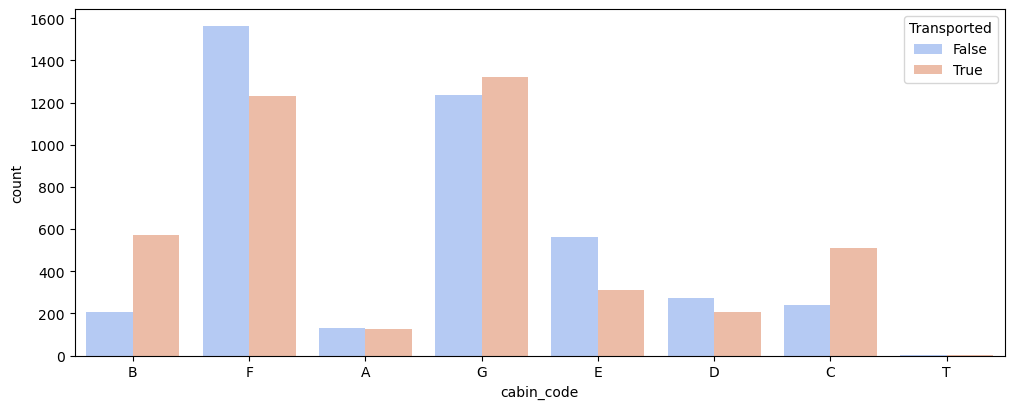

In [71]:
plt.figure(figsize=(12, 4.5))
_= sns.countplot(data=df, x="cabin_code", hue="Transported", palette="coolwarm")

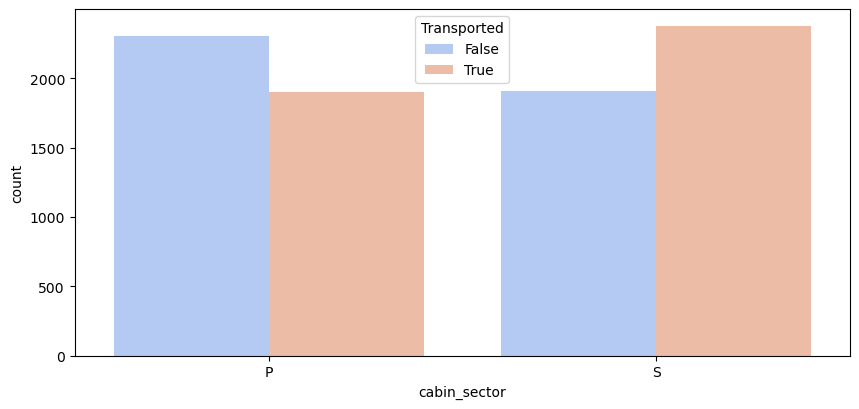

In [72]:
plt.figure(figsize=(10, 4.5))
_= sns.countplot(data=df, x="cabin_sector", hue="Transported", palette="coolwarm")

In [73]:
df.head(3)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,cabin_code,id_cabin,cabin_sector
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S


In [74]:
pop_id_cabin = df.pop("id_cabin")
df.insert(3, 'id_cabin', pop_id_cabin)  # Insert column 'C' at the beginning

pop_id_cabin = df.pop("cabin_sector")
df.insert(3, 'cabin_sector', pop_id_cabin)  # Insert column 'C' at the beg

pop_id_cabin = df.pop("cabin_code")
df.insert(3, 'cabin_code', pop_id_cabin)  # Insert column 'C' at the beg

In [75]:
df.head(4)

,HomePlanet,CryoSleep,Cabin,cabin_code,cabin_sector,id_cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,B,P,0,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,F,S,0,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A/0/S,A,S,0,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A/0/S,A,S,0,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False


In [76]:

#BINARY TRANSFORMATION
df["Transported"] = df["Transported"].map({True:1, False:0})


#DROPPING COLUMNS
df.drop(columns=["Cabin","id_cabin"], inplace=True)


#DROPPING NULLS
df.dropna(subset=["cabin_code"], inplace=True)


In [77]:
df.head(4)

,HomePlanet,CryoSleep,cabin_code,cabin_sector,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B,P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0
1,Earth,False,F,S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1
2,Europa,False,A,S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0
3,Europa,False,A,S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0


In [78]:
df.head(3)

,HomePlanet,CryoSleep,cabin_code,cabin_sector,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B,P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0
1,Earth,False,F,S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1
2,Europa,False,A,S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0


In [79]:
df.cabin_code.value_counts(1).sort_index()

cabin_code
A    0.030139
B    0.091712
C    0.087944
D    0.056275
E    0.103132
F    0.328938
G    0.301271
T    0.000589
Name: proportion, dtype: float64

In [80]:
#Define X and y

X = df.iloc[:,0:12]
y = df["Transported"]

In [81]:
#Data splitting

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.25)

In [82]:
#Separate categorical and numerical

cat_feat = np.array([coluna for coluna in X_train.columns if X_train[coluna].dtype.name == 'object'])

num_feat = np.array([coluna for coluna in X_train.columns if coluna not in cat_feat])

In [83]:
#Categorical and numerical pipelines


cat_pipe = Pipeline([("imputer_cat", SimpleImputer(strategy="most_frequent")),("encoder", ce.TargetEncoder()),
                    ])

num_pipe = Pipeline([("imputer_num", KNNImputer(n_neighbors=3))])


In [84]:
#Using ColumnTransformer 


transformer = ColumnTransformer([("num_trans", num_pipe, num_feat),
                            ("cat_trans", cat_pipe, cat_feat)])



In [85]:
# ".fit_transform" in train data"

# ".transform" in test data"

X_train_transformed = transformer.fit_transform(X_train, y_train)
X_test_transformed = transformer.transform(X_test)


In [86]:
def cross_valid(X_train, y_train2):
    # Define models
    models = [
        ("XGBoost", xgb.XGBClassifier()),
        ("XGBLinear", xgb.XGBClassifier(booster="gblinear")),
        ("LightGBM", LGBMClassifier(verbose=-1)),
        ("XGBoost50", xgb.XGBClassifier(n_estimators=50)),
        ("XGBoost0.3", xgb.XGBClassifier(learning_rate=0.3))
    ]
    
    # Cross-validation
    results = pd.DataFrame()
    mean = []
    deviation = []
    for name, model in models:
        skf = StratifiedKFold(n_splits=5, random_state=None)
        cv_results = cross_val_score(model, X_train, y_train2, cv=skf, scoring="accuracy")
        mean.append(cv_results.mean())
        deviation.append(cv_results.std())
    
    # Create DataFrame for results
    results["Model"] = [name for name, _ in models]
    results["Mean"] = mean
    results["Deviation"] = deviation
    
    # Create traces
    fig = go.Figure()
    
    # Add trace for mean
    fig.add_trace(go.Scatter(x=results["Model"], y=results["Mean"], mode='lines+markers', name='Mean',
                             line=dict(color='firebrick', width=2)))
    
    # Add trace for deviation with secondary y-axis
    fig.add_trace(go.Scatter(x=results["Model"], y=results["Deviation"], mode='lines+markers', name='Deviation',
                             line=dict(color='royalblue', width=2), yaxis='y2'))
    
    # Update layout
    fig.update_layout(title='Model Performance with Cross-Validation',
                      xaxis_title='Models',
                      yaxis=dict(title='Mean', titlefont=dict(color='firebrick')),
                      yaxis2=dict(title='Deviation', titlefont=dict(color='royalblue'),
                                  overlaying='y', side='right'),
                      legend=dict(x=0.02, y=0.98),
                      plot_bgcolor='rgba(0,0,0,0)',
                      margin=dict(l=50, r=50, t=50, b=50),
                      font=dict(family="Arial", size=12, color="black"))
    
    # Show plot
    fig.show()

In [87]:
cross_valid(X_train_transformed,y_train)

In [88]:
lgbmc = LGBMClassifier()


In [89]:


lgbm_params = {"n_estimators":[100,200,300], 
               "learning_rate":[0.01,0.05,0.1,0.3],
               "max_depth":[20,50,80,100]}



In [90]:
grid_search = GridSearchCV (estimator = lgbmc,
                            param_grid = lgbm_params,
                            n_jobs=-1,
                            cv = 5,
                            scoring="accuracy",
                           error_score='raise')
                        

In [91]:
grid_result = grid_search.fit(X_train_transformed, y_train)


final_model = lgbmc.set_params(**grid_result.best_params_)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3226, number of negative: 3144
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1385
[LightGBM] [Info] Number of data points in the train set: 6370, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506436 -> initscore=0.025747
[LightGBM] [Info] Start training from score 0.025747


In [92]:

#training the model
final_model.fit(X_train_transformed, y_train)


#predictions
y_pred = final_model.predict(X_test_transformed)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3226, number of negative: 3144
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1385
[LightGBM] [Info] Number of data points in the train set: 6370, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506436 -> initscore=0.025747
[LightGBM] [Info] Start training from score 0.025747
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [93]:
precision = precision_score(y_pred, y_test)
precision

0.8374524714828897

In [94]:
accuracy = accuracy_score(y_pred, y_test)
accuracy

0.8116760828625236

In [95]:
recall = precision_score(y_pred, y_test)
recall

0.8374524714828897

In [96]:
f1 = f1_score(y_pred, y_test)
f1

0.814986123959297

In [97]:
precision = precision_score(y_pred, y_test)
accuracy = accuracy_score(y_pred, y_test)
recall = precision_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

score = []
score.append(("precision", precision))
score.append(("accuracy",accuracy))
score.append(("recall",recall))
score.append(("f1",f1))

score= pd.DataFrame(score)
score.rename(columns={0: "Metric", 1:"Result"}, inplace=True)

In [98]:
#Metrics obtained

display(score)

,Metric,Result
0,precision,0.837452
1,accuracy,0.811676
2,recall,0.837452
3,f1,0.814986


In [99]:
print(f"Precision: {score.iloc[0,1]:.4f}")
print(f"Accuracy: {score.iloc[1,1]:.4f}")
print(f"F1_Score: {score.iloc[2,1]:.4f}")
print(f"Recall: {score.iloc[3,1]:.4f}")

Precision: 0.8375
Accuracy: 0.8117
F1_Score: 0.8375
Recall: 0.8150


- Precision: 0.8470
- Accuracy: 0.8112
- F1_Score: 0.8470
- Recall: 0.8163

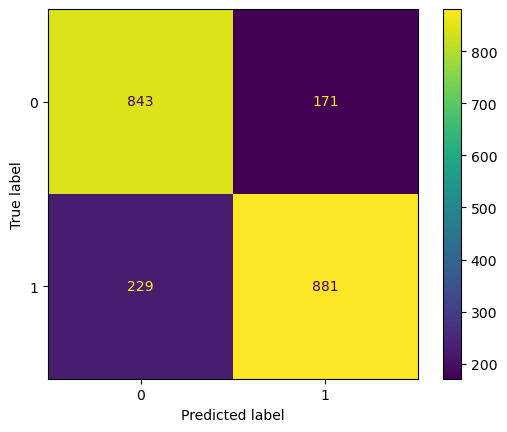

In [100]:
confusions_matrix = confusion_matrix(y_pred, y_test)

from sklearn.metrics import ConfusionMatrixDisplay

conf_disp = ConfusionMatrixDisplay(confusion_matrix=confusions_matrix)

conf_disp.plot()

In [102]:
testecsv = pd.read_csv("testspace.csv")

In [103]:
testecsv.head(6)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
5,0027_01,Earth,False,F/7/P,TRAPPIST-1e,31.0,False,0.0,1615.0,263.0,113.0,60.0,Karlen Ricks


In [104]:
testecsv[["cabin_code","id_cabin","cabin_sector"]] = testecsv["Cabin"].str.split("/", n=2, expand=True)

In [105]:
testecsv.drop(columns=["id_cabin"], inplace=True)

In [106]:
X_teste = testecsv.drop(columns=["PassengerId","Cabin","Name"])


In [107]:
testecsv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
 13  cabin_code    4177 non-null   object 
 14  cabin_sector  4177 non-null   object 
dtypes: float64(6), object(9)
memory usage: 501.3+ KB


In [108]:
model = final_model

In [109]:
X.dropna(subset=["cabin_code"], inplace=True)

In [110]:
X = transformer.fit_transform(X,y)
X_teste = transformer.transform(X_teste)

In [111]:
model.fit(X, y)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 4278, number of negative: 4216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1388
[LightGBM] [Info] Number of data points in the train set: 8494, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503650 -> initscore=0.014599
[LightGBM] [Info] Start training from score 0.014599


LGBMClassifier(learning_rate=0.05, max_depth=20, n_estimators=200)

In [112]:
y_predz = model.predict(X_teste)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [113]:
subimisspace = pd.Series(index = testecsv["PassengerId"].values, data = y_predz)

In [114]:
subimisspace = subimisspace.reset_index()

In [115]:
subimisspace = pd.DataFrame(subimisspace)
subimisspace

,index,0
0,0013_01,1
1,0018_01,0
2,0019_01,1
3,0021_01,1
4,0023_01,1
...,...,...
4272,9266_02,1
4273,9269_01,0
4274,9271_01,1
4275,9273_01,1


In [116]:
subimisspace[0]=subimisspace[0].map({1:"True", 0:"False"})


In [117]:
subimisspace.rename(columns = {"index":"PassengerId", 0:"Transported"}, inplace=True)

In [159]:
subimisspace.to_csv("testy.csv", index=False)

In [160]:
subimisspace

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,True
4274,9271_01,True
4275,9273_01,False
